###  Clustering


In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

### Create data

In [3]:
n_clusters= 6
n_samples = 250

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.76,  29.05],
        [ -8.20,  32.15],
        [ -7.67,   7.06],
        [-17.04,  20.55],
        [ 30.85, -25.68],
        [ 30.42,   6.55]])

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m): return MultivariateNormal(
    m,
    torch.diag(tensor([5.,5]))
).sample((n_samples,))

In [7]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='m', mew=2)

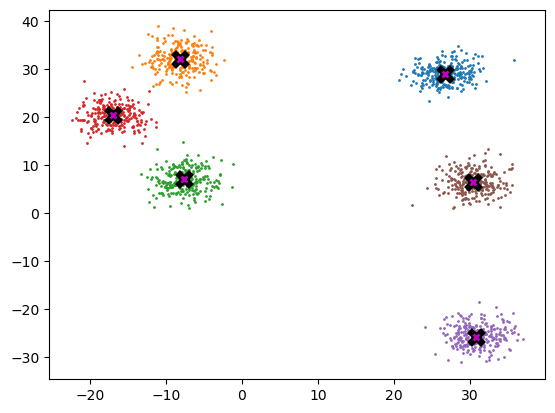

In [9]:
plot_data(centroids, data, n_samples)

### Mean shift

In [10]:
midp = data.mean(0)
midp

tensor([ 9.22, 11.60])

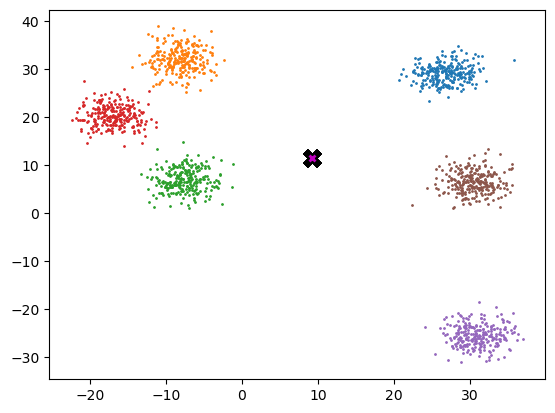

In [11]:
plot_data([midp]*6, data, n_samples)

In [12]:
def gaussian(d,bw): return torch.exp(-0.5*(d/bw)**2)/(bw*math.sqrt(2*math.pi))

In [13]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x,f(x))

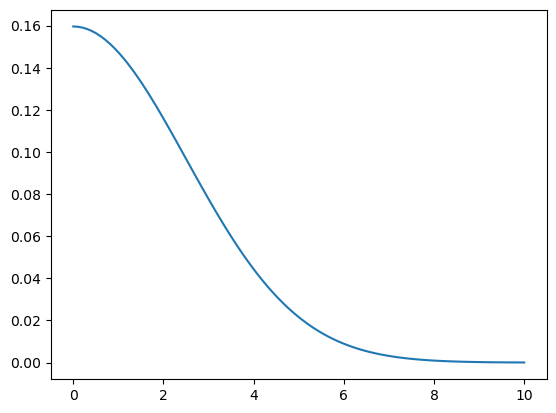

In [14]:
plot_func(partial(gaussian, bw=2.5))

In [15]:
def tri(d,i): return (-d+i).clamp_min(0)+1

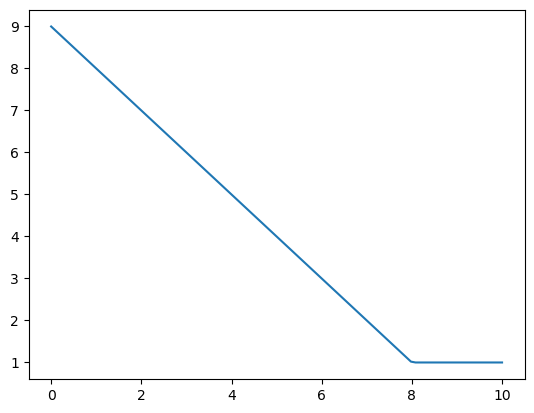

In [16]:
plot_func(partial(tri, i=8))

In [17]:
X = data.clone()
x = data[0]

In [18]:
x

tensor([26.20, 26.35])

In [19]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [20]:
(x[None]-X)[:8]

tensor([[ 0.00,  0.00],
        [ 0.51, -3.86],
        [-4.23, -2.34],
        [ 0.56, -3.68],
        [-5.03, -3.74],
        [-4.07, -0.64],
        [-3.42, -5.60],
        [-1.92, -5.69]])

In [21]:
# Homework: rewrite using einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.00, 3.90, 4.83, 3.73, 6.27, 4.12, 6.56, 6.00])

In [22]:
bla = tensor([1., 2, 3])

In [23]:
torch.einsum('i,i->i', bla, bla), torch.einsum('i,i->', bla, bla)

(tensor([1., 4., 9.]), tensor(14.))

In [24]:
blub = tensor([[1., 2], [3, 4]])
blub

tensor([[1., 2.],
        [3., 4.]])

In [25]:
torch.einsum('ij,ij->ij', blub, blub), torch.einsum('ij,ij->i', blub, blub)

(tensor([[ 1.,  4.],
         [ 9., 16.]]),
 tensor([ 5., 25.]))

In [26]:
# Done Homework: rewrite using einsum
dist = torch.einsum('ij,ij->i',x-X,x-X).sqrt()
dist[:8]

tensor([0.00, 3.90, 4.83, 3.73, 6.27, 4.12, 6.56, 6.00])

In [27]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.16,     0.05,     0.02,  ...,     0.00,     0.00,     0.00])

In [28]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [29]:
weight[:,None].shape

torch.Size([1500, 1])

In [30]:
weight[:,None]*X

tensor([[    4.18,     4.20],
        [    1.22,     1.43],
        [    0.75,     0.71],
        ...,
        [    0.00,     0.00],
        [    0.00,     0.00],
        [    0.00,     0.00]])

In [31]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [32]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [33]:
%time X=meanshift(data)

CPU times: user 1.18 s, sys: 333 µs, total: 1.18 s
Wall time: 1.18 s


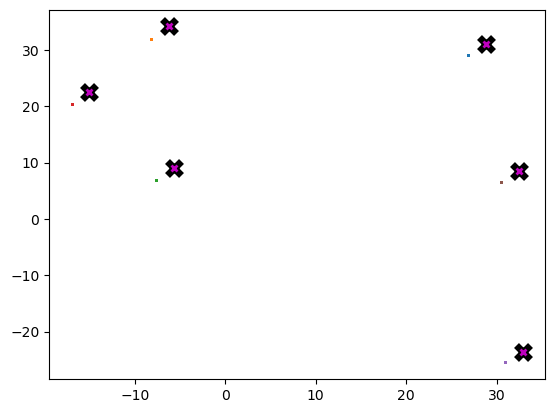

In [34]:
plot_data(centroids+2, X, n_samples)

### Animation

In [35]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [36]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [37]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml()) 

### GPU batched algorithm

In [38]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [39]:
# Note Umer: dist, but for a batch of points
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [40]:
# X[None].shape = 1, 1500, 2
# x[:,None].shape = 5,1, 2

In [41]:
dist_b(X, x)

tensor([[ 0.00,  3.90,  4.83,  ..., 17.63, 22.61, 21.62],
        [ 3.90,  0.00,  4.98,  ..., 21.50, 26.51, 25.50],
        [ 4.83,  4.98,  0.00,  ..., 19.37, 24.76, 23.40],
        [ 3.73,  0.19,  4.97,  ..., 21.33, 26.34, 25.33],
        [ 6.27,  5.55,  1.61,  ..., 20.78, 26.20, 24.78]])

In [42]:
X[None].shape, x[:,None].shape, (X[None]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [43]:
weight = gaussian(dist_b(X,x),2)
weight

tensor([[    0.20,     0.03,     0.01,  ...,     0.00,     0.00,     0.00],
        [    0.03,     0.20,     0.01,  ...,     0.00,     0.00,     0.00],
        [    0.01,     0.01,     0.20,  ...,     0.00,     0.00,     0.00],
        [    0.04,     0.20,     0.01,  ...,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.14,  ...,     0.00,     0.00,     0.00]])

In [44]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [45]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [46]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [47]:
num_via_einsum = torch.einsum('bs,sd->bd', weight, X)
num_via_einsum.shape

torch.Size([5, 2])

In [48]:
num

tensor([[367.87, 386.23],
        [518.33, 588.68],
        [329.67, 330.78],
        [527.62, 598.22],
        [231.30, 234.15]])

In [49]:
num_via_einsum

tensor([[367.87, 386.23],
        [518.33, 588.68],
        [329.67, 330.78],
        [527.62, 598.22],
        [231.30, 234.15]])

In [50]:
weight@X

tensor([[367.87, 386.23],
        [518.33, 588.68],
        [329.67, 330.78],
        [527.62, 598.22],
        [231.30, 234.15]])

In [51]:
weight.sum(1, keepdim=True)

tensor([[13.95],
        [19.86],
        [11.41],
        [20.24],
        [ 7.89]])

In [52]:
weight.sum(1)

tensor([13.95, 19.86, 11.41, 20.24,  7.89])

In [53]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [54]:
num/div

tensor([[26.38, 27.69],
        [26.10, 29.64],
        [28.89, 28.99],
        [26.07, 29.56],
        [29.32, 29.69]])

In [55]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X,X[s]),2.5)
            # weight = tri(dist_b(X,X[s]),8)
            div = weight.sum(1, keepdim=True)
            X[s] = (weight@X)/div
    return X

In [56]:
data = data.cuda()

In [57]:
X = meanshift(data).cpu()

In [58]:
%timeit -n 5 meanshift(data, 1250).cpu()

3.96 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


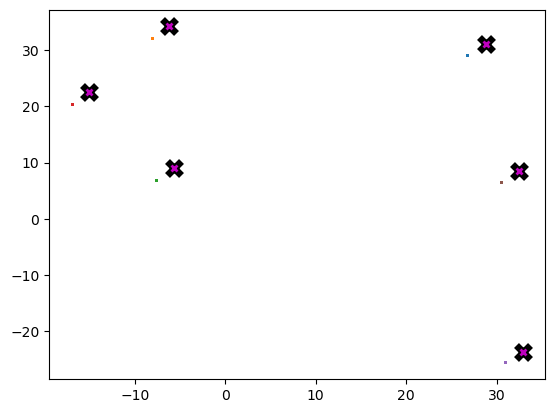

In [59]:
plot_data(centroids+2,X,n_samples)

### Homwork

Implement k-means clustering / dbscan / locality sensitive hashing on GPU

#### k-means

Pseudocode for K-Means Clustering (adapted from [src](https://towardsdatascience.com/k-means-clustering-introduction-to-machine-learning-algorithms-c96bf0d5d57a))

1. Choose K = # clusters, and obtain the data points 
2. Place K centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End 

Plan:
- create centroids (or use from above)
- do one update
- loop

In [60]:
X = data.clone().cuda()
x = X[0]
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([2]))

Goal: find_nearest_cluster

In [61]:
centroids = centroids.cuda()

In [62]:
dist_b(centroids,X[:2]).shape, dist_b(centroids,X[:2])

(torch.Size([2, 6]),
 tensor([[ 2.76, 34.89, 38.98, 43.63, 52.23, 20.24],
         [ 1.58, 33.95, 40.61, 43.81, 56.13, 24.13]], device='cuda:0'))

In [63]:
torch.min(dist_b(centroids,X[:2]), axis=1)

torch.return_types.min(
values=tensor([2.76, 1.58], device='cuda:0'),
indices=tensor([0, 0], device='cuda:0'))

In [64]:
torch.argmin(dist_b(centroids,X[:2]), axis=1)

tensor([0, 0], device='cuda:0')

In [65]:
def nearest_centroid_b(centroids,x): return torch.argmin(dist_b(centroids,x),axis=1)

In [66]:
nearest_centroid_b(centroids,X[:2])

tensor([0, 0], device='cuda:0')

In [67]:
# def do_one_step

# for all data points: find nearest centroids
# move centroids

In [68]:
nearest_centroids = nearest_centroid_b(centroids,X[:10])
nearest_centroids

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [69]:
X[:10][nearest_centroids==0].sum(axis=0)

tensor([273.08, 294.17], device='cuda:0')

In [70]:
def do_one_step(centroids, X):  # K,2 | n_samples,2 
    # to gpu
    centroids = centroids.cuda()
    X = X.cuda()
    # find nearest centroids
    nearest_centroids = nearest_centroid_b(centroids,X)  # n_samples, K
    # reposition centroids:
    for k in range(len(centroids)): centroids[k] = X[nearest_centroids==k].mean(axis=0)
    return centroids  # K,2

In [71]:
def random_centroids(K): return torch.rand(K, 2)*70-35

In [72]:
my_centroids = random_centroids(K=6)
my_centroids

tensor([[ -7.81, -21.11],
        [-15.16,   2.18],
        [ -6.22,  16.94],
        [-19.37,  -9.96],
        [-34.69,  28.57],
        [ -6.59, -27.59]])

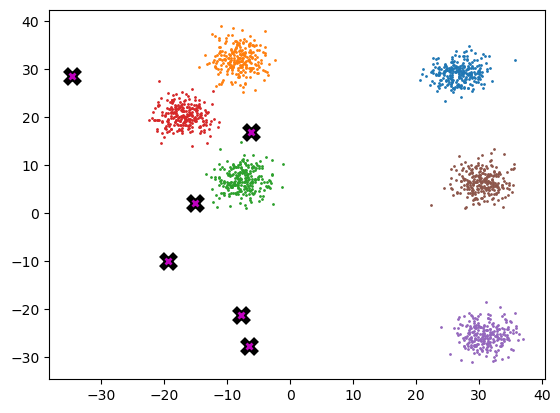

In [73]:
plot_data(my_centroids.cpu(), X.cpu(), n_samples)

Now let's check if doing multiple steps also works.

In [74]:
for _ in range(5):
    do_one_step(my_centroids, X)
    print(my_centroids[:1])

tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])


In [75]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [76]:
def do_one(d):
    if d: do_one_step(my_centroids, X)
    ax.clear()
    plot_data(my_centroids.cpu()+2, X.cpu(), n_samples, ax=ax)

fig,ax = plt.subplots()
ani = FuncAnimation(fig,do_one,frames=5,repeat=False)
plt.close()
HTML(ani.to_jshtml())